# Experimento 2: _One Vs All_

Realizando classificação com KNN usando para treino os arquivos `chbNN_com_dwt.csv` onde `NN` pertence ao `chb_set`, com exceção do que será usado para teste.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from seaborn import heatmap
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# lista de str ['01', '02', ..., '24']
file_range = ['{:0>2}'.format(chb) for chb in range(1, 25)]

def dataframe_from_chb(chb_number:str):
    df = pd.read_csv(f'./chb{chb_number}/chb{chb_number}_com_dwt.csv')
    df['chb'] = chb_number
    return df

chb_df = pd.concat([dataframe_from_chb(file) for file in file_range], ignore_index=True)


some_6_channels = ['2', '3', '6', '7', '14', '15']
some_8_channels = some_6_channels + ['5', '1']

# Filtrando colunas do chb que são referentes aos canais em some_6_channels
columns_from_6_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_6_channels]

# Filtrando colunas do chb que são referentes aos canais em some_8_channels
columns_from_8_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_8_channels]

In [2]:
acc_df_list = []

proba_dict = {
    file:{
        channel:np.array([]) for channel in ['all', '6ch', '8ch']
    } for file in file_range
}

for file in file_range:

    # Separando dados de treino e teste
    chb_copy_df = chb_df.copy()

    chb_train = chb_copy_df.query('chb != @file')
    chb_test = chb_copy_df.query('chb == @file')

    chb_train.pop('chb')
    chb_test.pop('chb')

    y_train = chb_train.pop('target').values
    y_test = chb_test.pop('target').values

    # Para 20 rodadas com todos os canais
    X_all = chb_train.values

    # Para 20 rodadas com os 6 canais
    X_6_channels = chb_train[columns_from_6_channels].values

    # Para 20 rodadas com os 8 canais
    X_8_channels = chb_train[columns_from_8_channels].values

    # Instanciando e treinando classificadores
    model_all = KNeighborsClassifier().fit(X_all, y_train)
    model_6_ch = KNeighborsClassifier().fit(X_6_channels, y_train)
    model_8_ch = KNeighborsClassifier().fit(X_8_channels, y_train)

    # gerando probabilidades
    proba_all = model_all.predict_proba(chb_test.values)
    proba_6ch = model_6_ch.predict_proba(chb_test[columns_from_6_channels].values)
    proba_8ch = model_8_ch.predict_proba(chb_test[columns_from_8_channels].values)

    # Salvando probabilidades em dicionário
    for channel, proba_arr in zip(['all', '6ch', '8ch'], [proba_all, proba_6ch, proba_8ch]):
        pos_sample, neg_sample = [], []

        for proba, target in zip(proba_arr, y_test):
            pos_sample.append(proba) if target == 1 else neg_sample.append(proba)

        proba_dict[file][channel] = np.array([neg_sample, pos_sample])

    # Formando dataframe de acurácias
    acc_df = pd.DataFrame(data=[file], columns=['chb'], dtype=np.float64)
    acc_df['all channels'] = model_all.score(chb_test.values, y_test)
    acc_df['2_3_6_7_14_15 channels'] = model_6_ch.score(chb_test[columns_from_6_channels].values, y_test)
    acc_df['2_3_6_7_14_15_5_1 channels'] = model_8_ch.score(chb_test[columns_from_8_channels].values, y_test)

    acc_df_list.append(acc_df)

one_vs_all_df = pd.concat(acc_df_list, ignore_index=True).sort_values(by='chb')
one_vs_all_df.to_csv('./csvs/oneVSall.csv', index=False)

## Metricas

In [3]:
one_vs_all_df = pd.read_csv('./csvs/oneVSall.csv')
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:]).hide_index()

In [4]:
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:], axis='columns').hide_index()

## Descrição geral

all channels  2_3_6_7_14_15 channels  2_3_6_7_14_15_5_1 channels
count     24.000000               24.000000                   24.000000
mean       0.763063                0.750446                    0.749754
std        0.171885                0.181577                    0.184195
min        0.352941                0.338235                    0.323529
25%        0.701746                0.679664                    0.700466
50%        0.800285                0.845995                    0.823962
75%        0.900563                0.868342                    0.873839
max        0.949495                0.939394                    0.949495

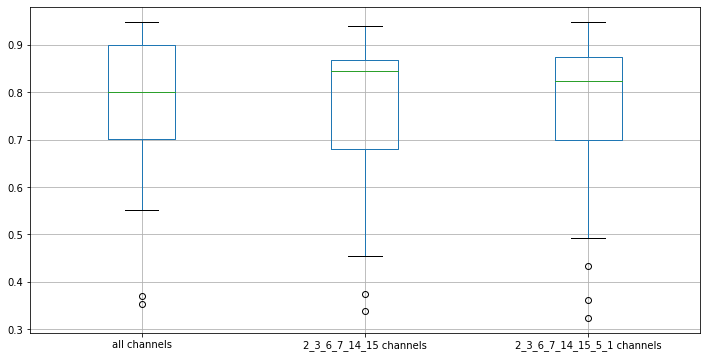

In [5]:
one_vs_all_df[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df[one_vs_all_df.columns[1:]].describe()

[[Text(0, 0, 'todos os canais'), Text(0, 0, 'canais 2_3_6_7_14_15')]]

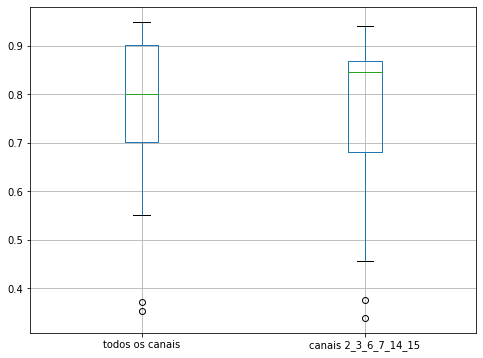

In [18]:
one_vs_all_df[['all channels', '2_3_6_7_14_15 channels']]\
    .boxplot(figsize=(8, 6))\
        .set(xticklabels=['todos os canais', 'canais 2_3_6_7_14_15'])

## Descrição excluindo os dois piores chb

all channels  2_3_6_7_14_15 channels  2_3_6_7_14_15_5_1 channels
count     19.000000               19.000000                   19.000000
mean       0.835391                0.824484                    0.822702
std        0.090759                0.106329                    0.113389
min        0.588235                0.463235                    0.433824
25%        0.780134                0.792535                    0.785618
50%        0.833333                0.860656                    0.848592
75%        0.906953                0.873724                    0.882840
max        0.949495                0.939394                    0.949495

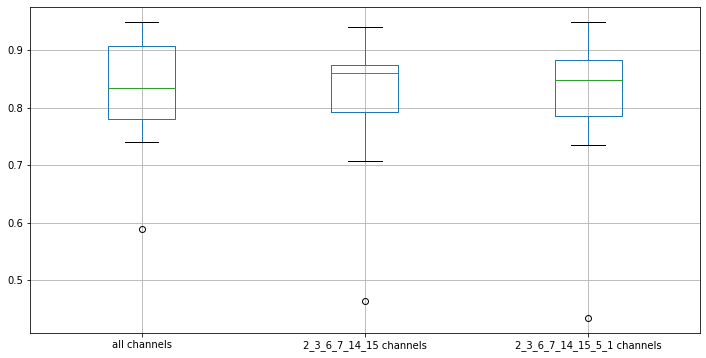

In [6]:
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].describe()

In [7]:
proba_dict['01']['all'].mean(axis=1).flatten()

array([0.80925926, 0.19074074, 0.09537037, 0.90462963])

# Observando margem de probabilidade para todos os canais de cada CHB

Margem de probabilidade para todos os canais do CHB 01
Para o grupo de canais all


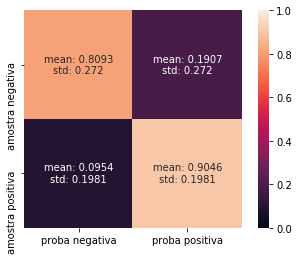

Para o grupo de canais 6ch


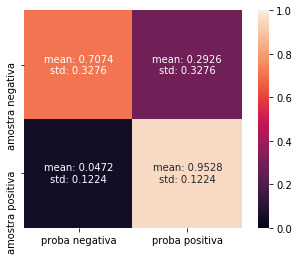

Para o grupo de canais 8ch


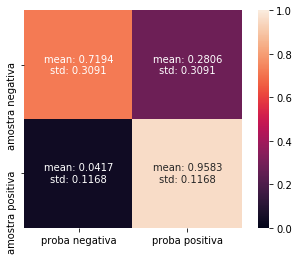

Margem de probabilidade para todos os canais do CHB 02
Para o grupo de canais all


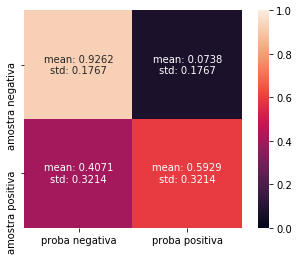

Para o grupo de canais 6ch


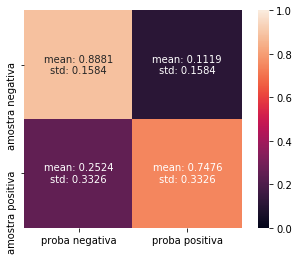

Para o grupo de canais 8ch


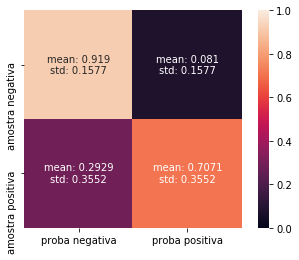

Margem de probabilidade para todos os canais do CHB 03
Para o grupo de canais all


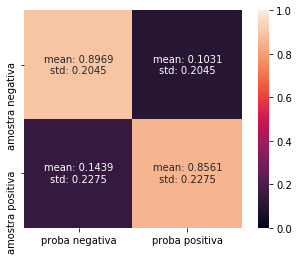

Para o grupo de canais 6ch


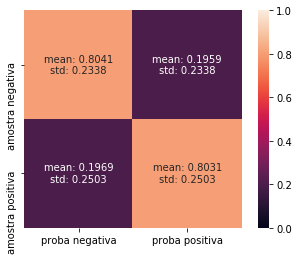

Para o grupo de canais 8ch


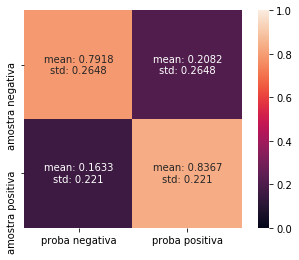

Margem de probabilidade para todos os canais do CHB 04
Para o grupo de canais all


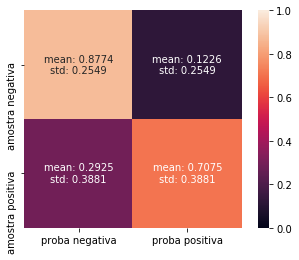

Para o grupo de canais 6ch


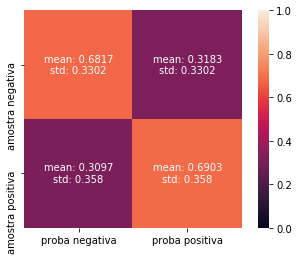

Para o grupo de canais 8ch


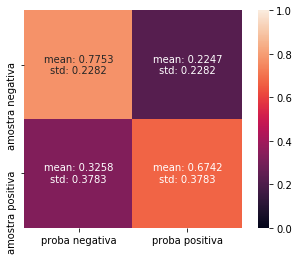

Margem de probabilidade para todos os canais do CHB 05
Para o grupo de canais all


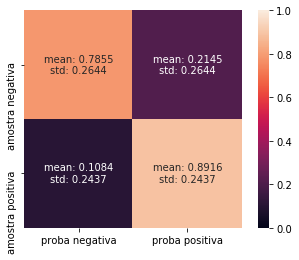

Para o grupo de canais 6ch


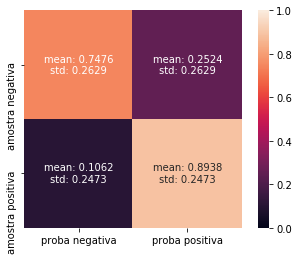

Para o grupo de canais 8ch


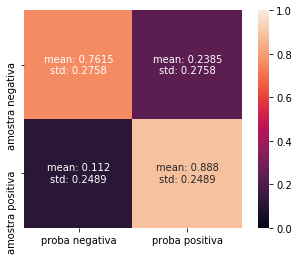

Margem de probabilidade para todos os canais do CHB 06
Para o grupo de canais all


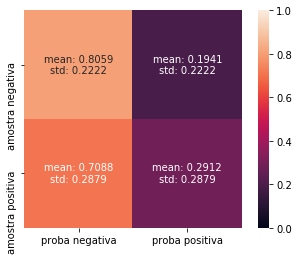

Para o grupo de canais 6ch


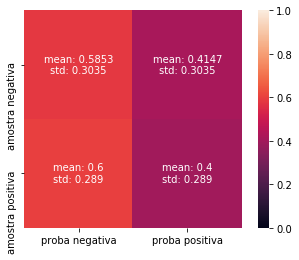

Para o grupo de canais 8ch


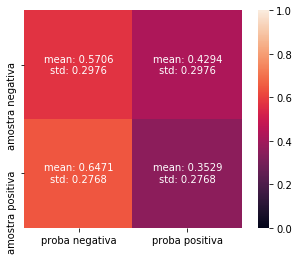

Margem de probabilidade para todos os canais do CHB 07
Para o grupo de canais all


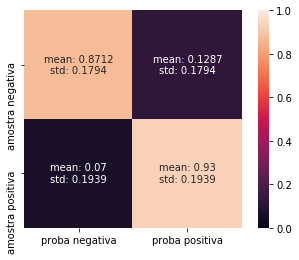

Para o grupo de canais 6ch


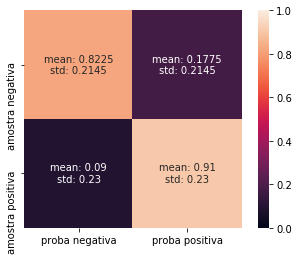

Para o grupo de canais 8ch


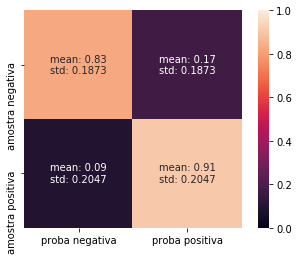

Margem de probabilidade para todos os canais do CHB 08
Para o grupo de canais all


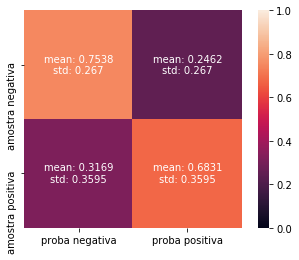

Para o grupo de canais 6ch


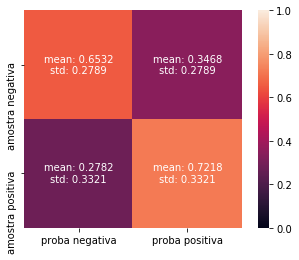

Para o grupo de canais 8ch


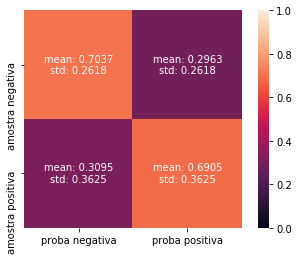

Margem de probabilidade para todos os canais do CHB 09
Para o grupo de canais all


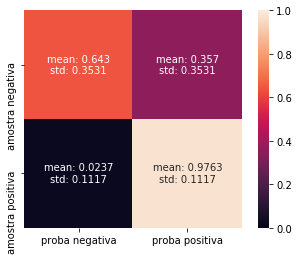

Para o grupo de canais 6ch


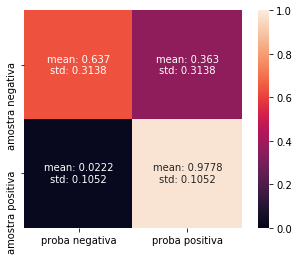

Para o grupo de canais 8ch


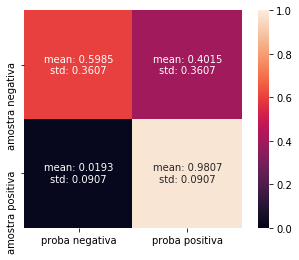

Margem de probabilidade para todos os canais do CHB 10
Para o grupo de canais all


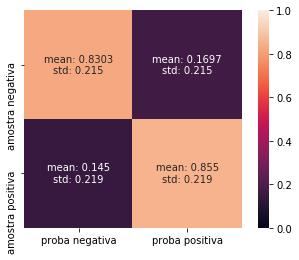

Para o grupo de canais 6ch


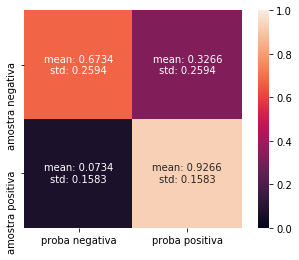

Para o grupo de canais 8ch


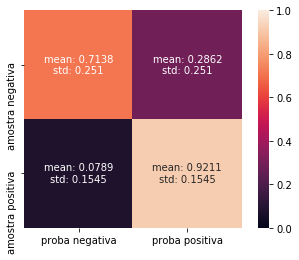

Margem de probabilidade para todos os canais do CHB 11
Para o grupo de canais all


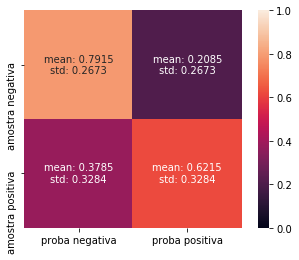

Para o grupo de canais 6ch


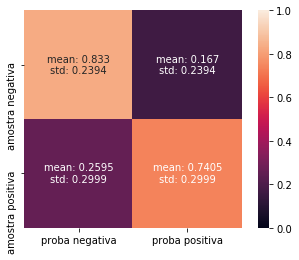

Para o grupo de canais 8ch


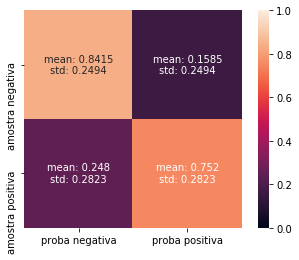

Margem de probabilidade para todos os canais do CHB 12
Para o grupo de canais all


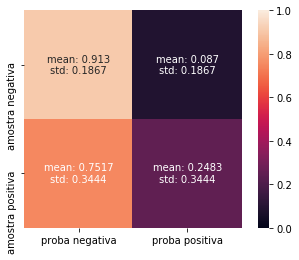

Para o grupo de canais 6ch


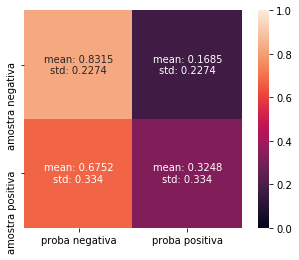

Para o grupo de canais 8ch


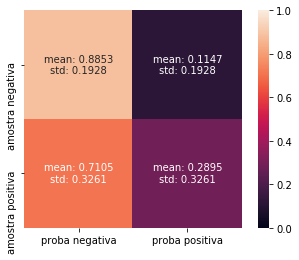

Margem de probabilidade para todos os canais do CHB 13
Para o grupo de canais all


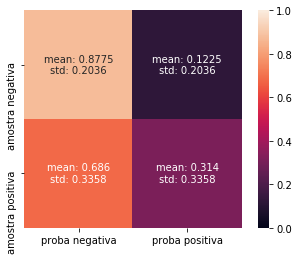

Para o grupo de canais 6ch


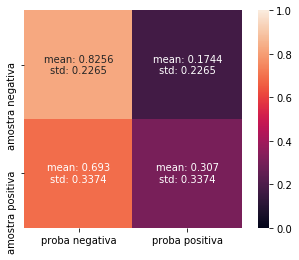

Para o grupo de canais 8ch


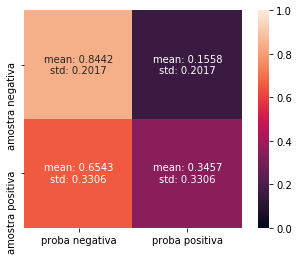

Margem de probabilidade para todos os canais do CHB 14
Para o grupo de canais all


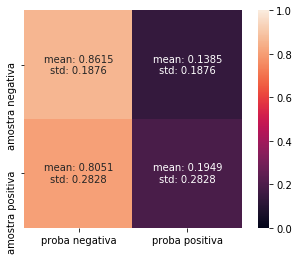

Para o grupo de canais 6ch


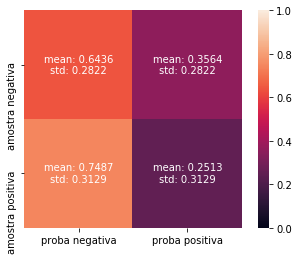

Para o grupo de canais 8ch


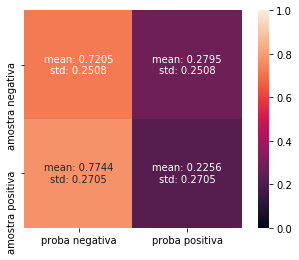

Margem de probabilidade para todos os canais do CHB 15
Para o grupo de canais all


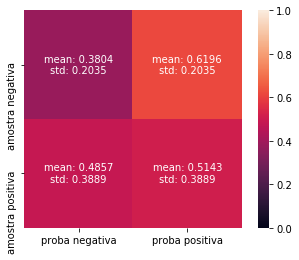

Para o grupo de canais 6ch


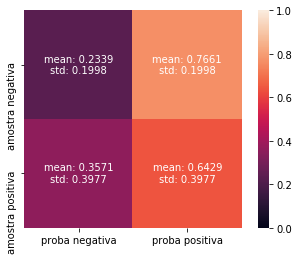

Para o grupo de canais 8ch


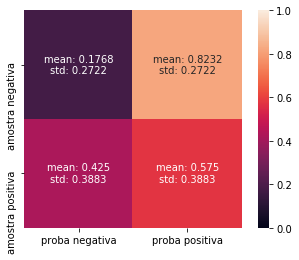

Margem de probabilidade para todos os canais do CHB 16
Para o grupo de canais all


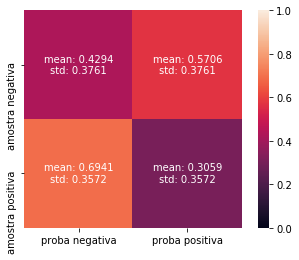

Para o grupo de canais 6ch


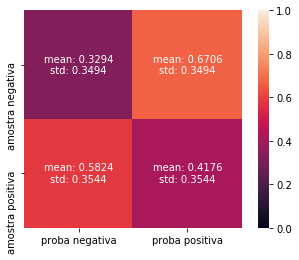

Para o grupo de canais 8ch


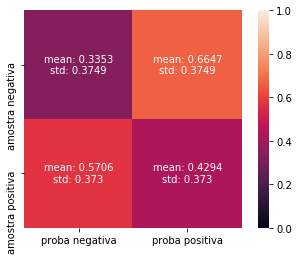

Margem de probabilidade para todos os canais do CHB 17
Para o grupo de canais all


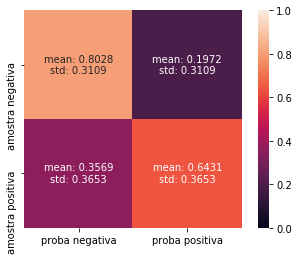

Para o grupo de canais 6ch


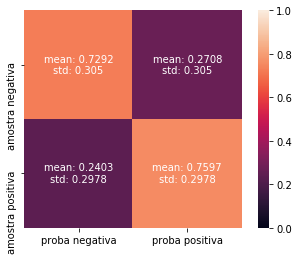

Para o grupo de canais 8ch


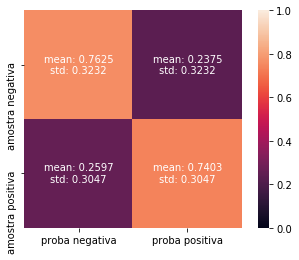

Margem de probabilidade para todos os canais do CHB 18
Para o grupo de canais all


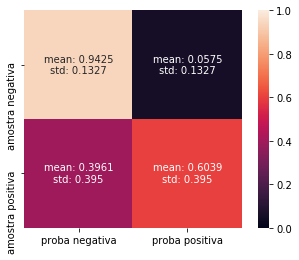

Para o grupo de canais 6ch


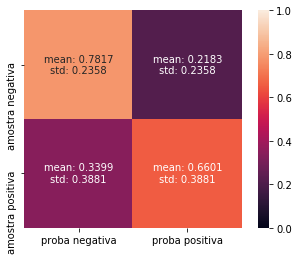

Para o grupo de canais 8ch


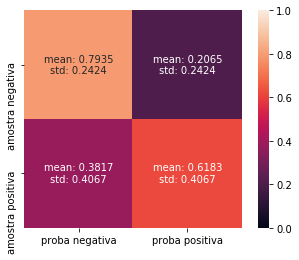

Margem de probabilidade para todos os canais do CHB 19
Para o grupo de canais all


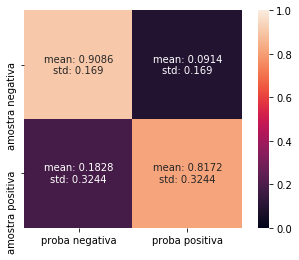

Para o grupo de canais 6ch


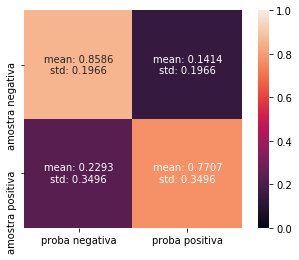

Para o grupo de canais 8ch


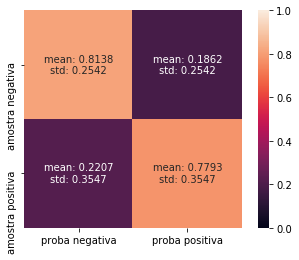

Margem de probabilidade para todos os canais do CHB 20
Para o grupo de canais all


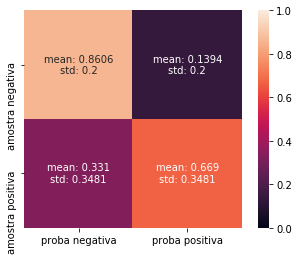

Para o grupo de canais 6ch


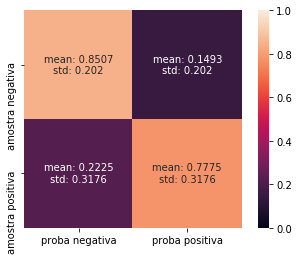

Para o grupo de canais 8ch


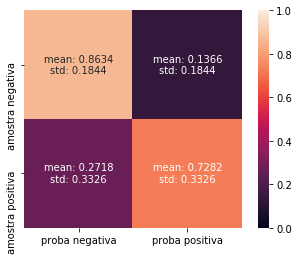

Margem de probabilidade para todos os canais do CHB 21
Para o grupo de canais all


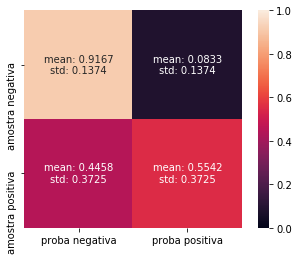

Para o grupo de canais 6ch


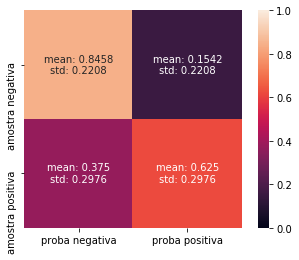

Para o grupo de canais 8ch


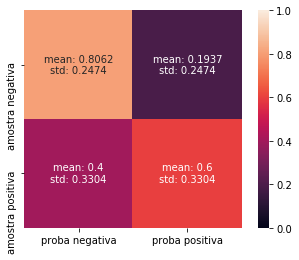

Margem de probabilidade para todos os canais do CHB 22
Para o grupo de canais all


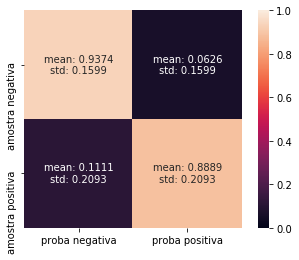

Para o grupo de canais 6ch


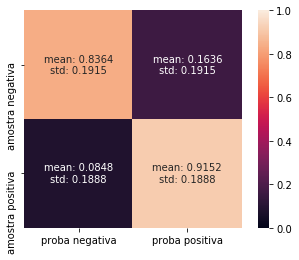

Para o grupo de canais 8ch


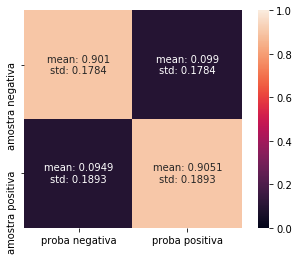

Margem de probabilidade para todos os canais do CHB 23
Para o grupo de canais all


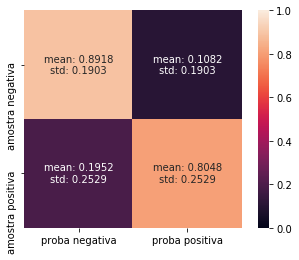

Para o grupo de canais 6ch


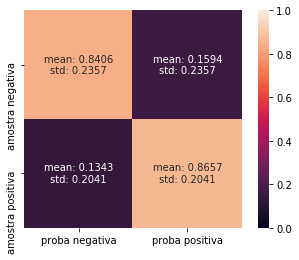

Para o grupo de canais 8ch


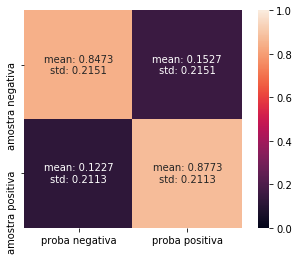

Margem de probabilidade para todos os canais do CHB 24
Para o grupo de canais all


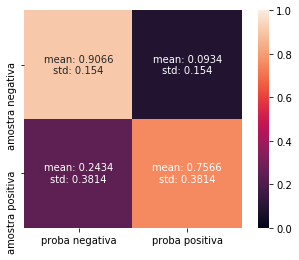

Para o grupo de canais 6ch


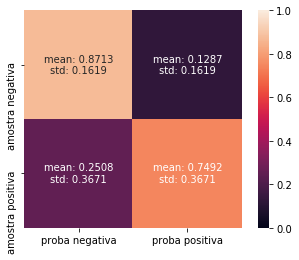

Para o grupo de canais 8ch


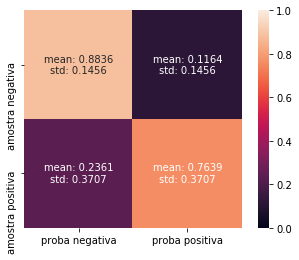

In [8]:
for chb in file_range:
    print(f'Margem de probabilidade para todos os canais do CHB {chb}')

    for channel in ['all', '6ch', '8ch']:
        print(f'Para o grupo de canais {channel}')

        mean_arr, std_arr = proba_dict[chb][channel].mean(axis=1), proba_dict[chb][channel].std(axis=1)
        annotations = \
            np.array(
                [f'mean: {round(mean, 4)}\nstd: {round(std, 4)}' for mean, std in zip(mean_arr.flatten(), std_arr.flatten())]
            ).reshape((2, 2))

        heatmap(
            data=mean_arr,
            annot=annotations,
            fmt='',
            cbar=True,
            vmin=0,
            vmax=1,
            square=True,
            xticklabels=['proba negativa', 'proba positiva'],
            yticklabels=['amostra negativa', 'amostra positiva']
        )

        plt.show()